<h2><strong>Ship Satellite Image Classification Using ResNet50 Transfer Learning Algorithm</strong></h2>

<strong>Trainee:</strong> Mesuga, Reymond R.


##<h3><strong>Mounting the Google Drive<strong></h3>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install split-folders

##<h3><strong>Importing Necessary Packages<strong></h3>

In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(42)
import cv2
import imutils as imutils
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # machine learning
from tqdm import tqdm # make your loops show a smart progress meter 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn
import splitfolders

from tensorflow.keras.applications import resnet50

from tensorflow.keras.applications.resnet50 import ResNet50


RANDOM_SEED = 42 # To make the outputs reproducible
IMG_SIZE = (80,80) # Given size of the images

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(42)
   tf.random.set_seed(42)
   np.random.seed(42)
   random.seed(42)

##<h3><strong>About the Dataset</strong></h3><br>
The dataset that will be used in this exercise is from a Kaggle repository named <a href="https://www.kaggle.com/rhammell/ships-in-satellite-imagery">Ships in Satellite Imagery</a>. This dataset contains image chips extracted from <a href="https://www.planet.com/">Planet Satellite Imagery</a> collected over the San Francisco Bay and San Pedro Bay areas of California. The total number of images in the dataset is 6400 with the size of 80x80 pixels which can be classified as ship or no-ship.

##<h3><strong>Splitting the Dataset</strong></h3><br>
The dataset will be splitted into three folders namely train, val, and test folder. The `train` folder contains the 80% of the images which will be used to train the algorithm. The `val` folder contains the images that will be used for hyperparameter tuning. While `test` folder contains the images that will be used to compute the final accuracy of the model.

<table>
  <tr>
  <th></th>
  <th>Training Set</th>
  <th>Validation Set</th>
  <th>Test Set</th>
  </tr>
  <tr>
  <td>ship</td>
  <td>800</td>
  <td>100</td>
  <td>100</td>
  </tr>
  <tr>
  <td>no-ship</td>
  <td>2400</td>
  <td>300</td>
  <td>300</td>
  </tr>
</table>

In [ ]:
%%time
!mkdir Splitted_Dataset
input_folder_path = "/content/drive/MyDrive/Personal-Project-Datasets/shipsnet"
output_folder_path = "Splitted_Dataset"
splitfolders.ratio(input_folder_path, output=output_folder_path, seed=42, ratio=(.8, .1, .1), group_prefix=None) # default values

mkdir: cannot create directory ‘Splitted_Dataset’: File exists


Copying files: 4000 files [00:13, 301.60 files/s]

CPU times: user 1.8 s, sys: 2.59 s, total: 4.39 s
Wall time: 13.4 s


In [ ]:
Training_Path = "/content/Splitted_Dataset/train/"
Validation_Path = "/content/Splitted_Dataset/val/"
Test_Path = "/content/Splitted_Dataset/test/"
os.listdir(Training_Path)

['no-ship', 'ship']

In [ ]:
def number_of_imgs(path):
  print(path)
  for value in os.listdir(path):
    print(value, "has", len(os.listdir(path + value)), "img", "\n")
number_of_imgs(Test_Path)
number_of_imgs(Training_Path)
number_of_imgs(Validation_Path)

/content/Splitted_Dataset/test/
no-ship has 300 img 

ship has 100 img 

/content/Splitted_Dataset/train/
no-ship has 2400 img 

ship has 800 img 

/content/Splitted_Dataset/val/
no-ship has 300 img 

ship has 100 img 



##<h3><strong>Data Visualization</strong></h3>

The codes below can randomly generate images from the folder of Training Set, Validation Set and Test Set.

In [ ]:
def create_dataframe(path):
    data = []
    for value in os.listdir(path):
        for image in os.listdir(path + value + "/"):
            file_path = path + value + "/" + image
            # if ship then set it to 1 else 0
            ship = 1 if value == "ship" else 0
            data.append({"path": file_path, 'ship': ship})
            
    df = pd.DataFrame(data=data).sample(frac=1).reset_index(drop=True)

    return df

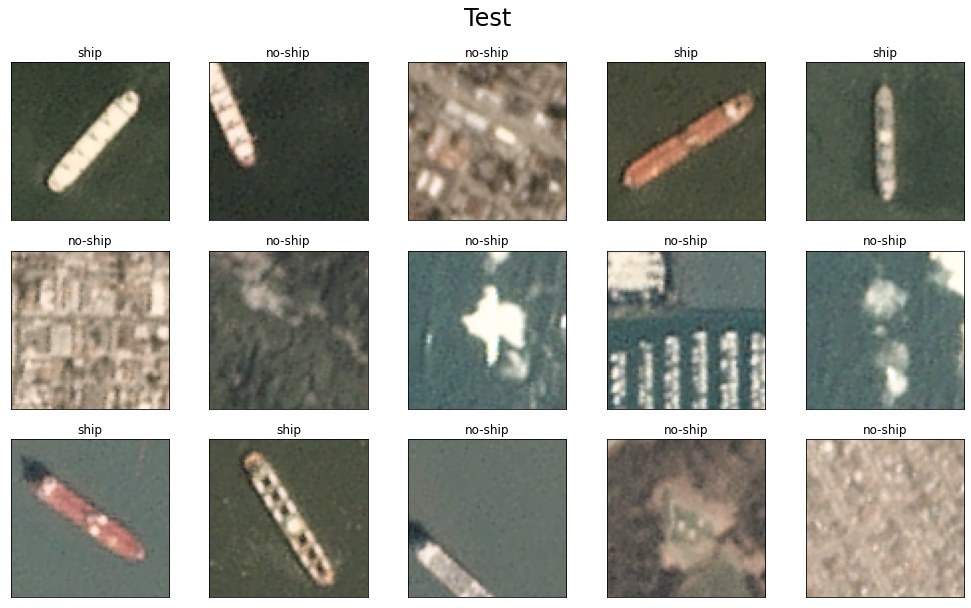

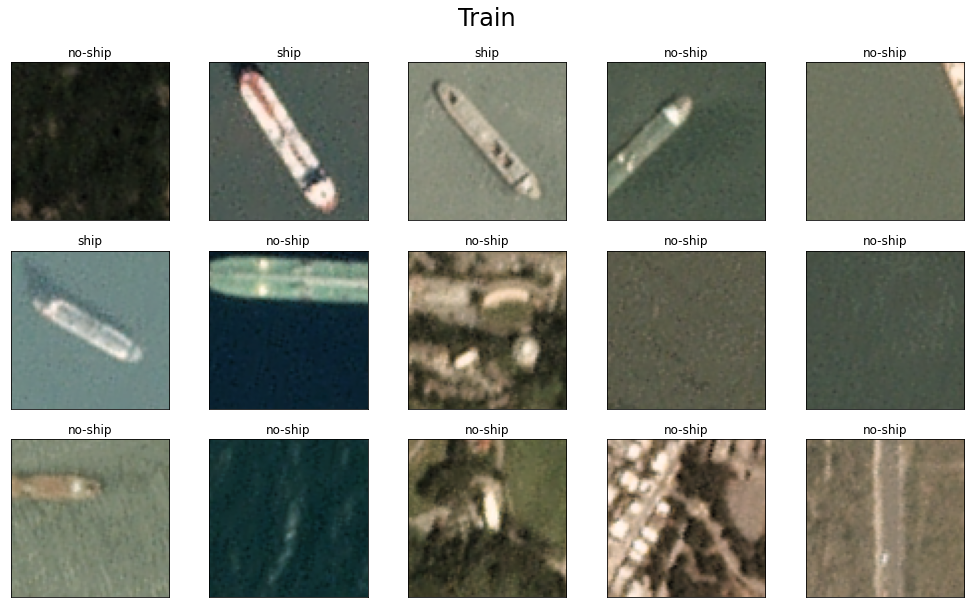

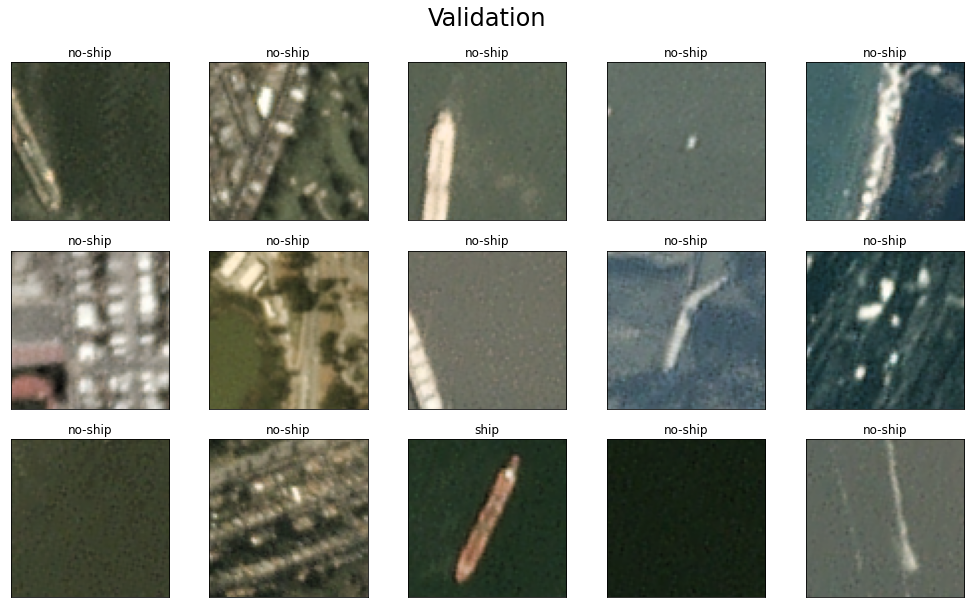

CPU times: user 3.5 s, sys: 309 ms, total: 3.81 s
Wall time: 3.47 s


In [ ]:
%%time
% matplotlib inline
def plot_imgs(title, paths):
    fig = plt.figure(figsize=(14, 8), dpi=72)
    fig.suptitle(title, fontsize=24, y=1.05)
    for i, row in paths.iterrows():
        img=mpimg.imread(row['path'])
        plt.subplot(3, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        subtitle = 'ship' if row['ship'] == 1 else 'no-ship'
        plt.title(subtitle)
        plt.imshow(img)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None)
    plt.show()
    
    
plot_imgs("Test", create_dataframe(Test_Path).sample(15).reset_index(drop=True))
plot_imgs("Train", create_dataframe(Training_Path).sample(15).reset_index(drop=True))
plot_imgs("Validation", create_dataframe(Validation_Path).sample(15).reset_index(drop=True))

##<h3><strong>Creating Data Generators</strong></h3><br>
Data generators or `datagens` enables us to feed the data into the model in batches and let the model study or classify the data in batches. This practice is very helpful to save a lot of memory during training.

In [ ]:
%%time
reset_random_seeds()
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    Training_Path,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=14,
    class_mode='binary',
    seed=RANDOM_SEED
)
validation_generator = val_datagen.flow_from_directory(
    Validation_Path,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=7,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 3200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
CPU times: user 118 ms, sys: 0 ns, total: 118 ms
Wall time: 338 ms


##<h3><strong>Model Building, Training and Evaluation</strong></h3>

###<h3><strong>Creating Helper Functions</strong></h3>
Helper functions are useful to avoid unnecessary repetitions of the code and make the source code more modular.

####<h5><strong>Helper Function for Building the Model</strong></h5>

In [ ]:
%%time
def model_builder(keras_model, droupout_rate, dense_node, activation_type, learning_rate):
  """
  keras_model = any model that can be imported from Keras applications.
  droupout_rate = Float between 0 and 1. Fraction of the input units to drop.
  dense_node = represents the number of units (neurons)
  activation_type = represent activation to be used
  learning_rate = A Tensor, floating point value. Defaults to 0.001.
  """
  reset_random_seeds()
  
  base_model = keras_model(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,)
  )

  model = tf.keras.models.Sequential()
  model.add(base_model)
  model.add(tf.keras.layers.Dropout(droupout_rate))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(dense_node,activation=activation_type))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  model.layers[0].trainable = False

  model.compile(
      loss='binary_crossentropy',
      optimizer=tf.keras.optimizers.Adam(learning_rate),
      metrics=['accuracy']
  )

  model.summary()
  return model

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


####<h5><strong>Helper Function for Training the Model</strong></h5>

In [ ]:
%%time
def model_trainer(model, epochs):
  """
  model = represents the model built using the function `model_builder`.
  epochs = defines the number times that the learning algorithm will work through the entire training dataset
  """
  reset_random_seeds()
  
  EPOCHS = epochs
  
  history = model.fit(
      train_generator,
      steps_per_epoch=50,
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=25,
  )
  print("Training Done")
  model_training_history = {"history": history,
                   "model": model
                   }
  return model_training_history

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


####<h5><strong>Helper Function for Visualization of the Training Results</strong></h5>

In [ ]:
def training_result_visualizer(Training_History):
  """
  Training_History = e.g., Training_History_ResNet50["history"]
  """
  reset_random_seeds()
  
  %matplotlib inline
  acc = Training_History.history["accuracy"]
  val_acc = Training_History.history["val_accuracy"]
  loss = Training_History.history["loss"]
  val_loss = Training_History.history["val_loss"]

  epochs_range = range(1, len(Training_History.epoch)+1)

  plt.figure(figsize=(10,5))

  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc="best")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Model Accuracy')
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.tight_layout()
  

  plt.figure(figsize=(10,5))

  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc="best")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Model Loss')
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.tight_layout()
  plt.show()

####<h5><strong>Helper Function for Validation and Test Accuracy</strong></h5>

In [ ]:
%%time
def Accuracy_Score(Path, model):
  reset_random_seeds()
  def preprocess_imgs(path, img_size):
    reset_random_seeds()
    set_new = []
    for value in os.listdir(path):
      for img in os.listdir(path + value):
        img = cv2.imread(path + value + "/" + img)
        set_new.append(tf.keras.applications.resnet50.preprocess_input(img))
    return np.array(set_new)

  test_data = preprocess_imgs(Path, img_size=IMG_SIZE)

  reality = []
  for value in os.listdir(Path):
    for img in os.listdir(Path + value):
      reality.append(1) if value == "no-ship" else reality.append(0)
  
  predictions = model.predict(test_data)
  predictions = [0 if x > 0.5 else 1 for x in predictions]

  accuracy = accuracy_score(reality, predictions)
  print("Accuracy:", accuracy)

  # Confusion Matrix
  confusion_mtx = confusion_matrix(reality, predictions)
  
  ax = plt.axes()
  sn.heatmap(confusion_mtx, annot=True, annot_kws={"size": 25}, cmap="Blues", ax=ax)
  ax.set_title('Confusion Matrix', size=14)
  plt.show() 

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


###<h5><strong>ResNet50: Defining the Model</strong></h5>

In [ ]:
%%time
Model_ResNet50 = model_builder(ResNet50, droupout_rate=0.5, dense_node=512, activation_type="relu", learning_rate=0.001)
Model_ResNet50

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 2048)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 3, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               9437696   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 33,034,113
Trainable params: 9,442,305
Non-trainable params: 23,591,808
____________________________________

###<h5><strong>ResNet50: Training the Model</strong></h5>

In [ ]:
%%time
Training_History_ResNet50 = model_trainer(Model_ResNet50, epochs=20)
Training_History_ResNet50

Epoch 1/20
50/50 [==============================] - 23s 410ms/step - loss: 1.8447 - accuracy: 0.8729 - val_loss: 1.8076 - val_accuracy: 0.9143
Epoch 2/20
50/50 [==============================] - 20s 392ms/step - loss: 0.1886 - accuracy: 0.9729 - val_loss: 0.0448 - val_accuracy: 0.9829
Epoch 3/20
50/50 [==============================] - 19s 389ms/step - loss: 0.0521 - accuracy: 0.9900 - val_loss: 0.0358 - val_accuracy: 0.9943
Epoch 4/20
50/50 [==============================] - 19s 388ms/step - loss: 0.0357 - accuracy: 0.9928 - val_loss: 0.0148 - val_accuracy: 0.9943
Epoch 5/20
50/50 [==============================] - 19s 390ms/step - loss: 0.0627 - accuracy: 0.9885 - val_loss: 0.0073 - val_accuracy: 0.9943
Epoch 6/20
50/50 [==============================] - 19s 391ms/step - loss: 0.0090 - accuracy: 0.9971 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 7/20
50/50 [==============================] - 19s 390ms/step - loss: 0.0287 - accuracy: 0.9942 - val_loss: 0.0195 - val_accuracy: 0.9886

###<h5><strong>ResNet50: Visualization of the Training Results</strong></h5>

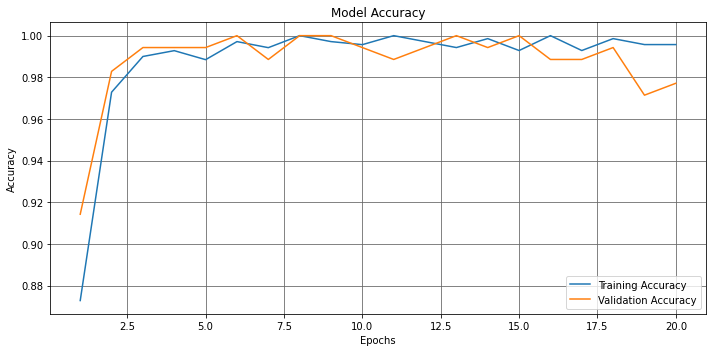

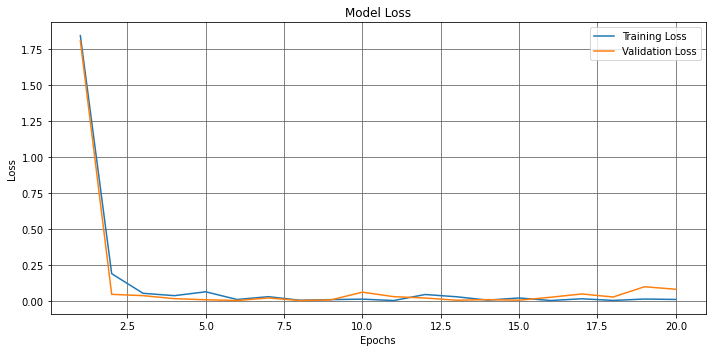

In [ ]:
ResNet50_Training_Results = training_result_visualizer(Training_History_ResNet50["history"])
ResNet50_Training_Results

###<h5><strong>ResNet50: Validation Accuracy</strong></h5>


Accuracy: 0.9775


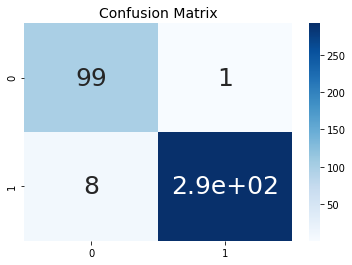

CPU times: user 12.7 s, sys: 479 ms, total: 13.2 s
Wall time: 7.54 s


In [ ]:
%%time
Accuracy_Score(Validation_Path, Training_History_ResNet50["model"])

##<h3><strong>Hyperparameter Tuning: Improving the Model</strong></h3>

###<h3><strong>Creating Helper Functions</strong></h3>
The helper functions here in hyperparameter tuning generates the plotted accuracy of different values of hyperparameter. This is to visualize better the performance of different values of hyperparameter and ease decision making.

####<h5><strong>Helper Function for Changing Dropout Rate</strong></h5>

In [ ]:
def Accuracy_Score_for_Tuning(Path, model):
  reset_random_seeds()
  def preprocess_imgs(path, img_size):
    reset_random_seeds()
    set_new = []
    for value in os.listdir(path):
      for img in os.listdir(path + value):
        img = cv2.imread(path + value + "/" + img)
        set_new.append(tf.keras.applications.resnet50.preprocess_input(img))
    return np.array(set_new)

  test_data = preprocess_imgs(Path, img_size=IMG_SIZE)

  reality = []
  for value in os.listdir(Path):
    for img in os.listdir(Path + value):
      reality.append(1) if value == "no-ship" else reality.append(0)
  
  predictions = model.predict(test_data)
  predictions = [0 if x > 0.5 else 1 for x in predictions]

  accuracy = accuracy_score(reality, predictions)
  return accuracy

In [ ]:
%%time
def param_tuning_with_dropout( keras_model, dropout_rates ):
  reset_random_seeds()
  Accuracy = []
  for rate in dropout_rates:
    reset_random_seeds()
    Model = model_builder(keras_model, rate, dense_node=512, activation_type="relu", learning_rate=0.001)

    Training_History_Model = model_trainer(Model, epochs=20)
    Training_History_Model
    print("_________________________________________________________________")
    print("Dropout Rate: ", rate)
  
    Model_Training_Results = training_result_visualizer(Training_History_Model["history"])
    Model_Training_Results

    accuracy = Accuracy_Score_for_Tuning(Validation_Path, Training_History_Model["model"])
    accuracy
    Accuracy.append(accuracy)

  print("This is the plot of the recorded Accuracy per Droupout Rate")
  print(Accuracy)
  plt.figure(figsize=(10,6))
  plt.title("Accuracy Curve: Dropout")
  plt.plot(dropout_rates, Accuracy, 'r-o')
  plt.xlabel("Dropout Rate")
  plt.ylabel('Accuracy')
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.tight_layout()
  plt.show()
  

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


####<h5><strong>Helper Function for Changing Activation Type</strong></h5>

In [ ]:
def param_tuning_with_activation( keras_model, activation_types ):
  reset_random_seeds()
  Accuracy = []
  for type in activation_types:
    reset_random_seeds()
    Model = model_builder(keras_model, droupout_rate=0.5, dense_node=512, activation_type=type, learning_rate=0.001)

    Training_History_Model = model_trainer(Model, epochs=20)
    Training_History_Model
    print("_________________________________________________________________")

    print("Activation Type: ", type)

    Model_Training_Results = training_result_visualizer(Training_History_Model["history"])
    Model_Training_Results

    accuracy = Accuracy_Score_for_Tuning(Validation_Path, Training_History_Model["model"])
    accuracy
    Accuracy.append(accuracy)
  
  print("This is the plot of the recorded Accuracy per Activation Type")
  print(Accuracy)
  plt.figure(figsize=(10,6))
  plt.title("Accuracy Curve: Activation")
  plt.plot(activation_types, Accuracy, 'r-o')
  plt.xlabel("Activation")
  plt.ylabel('Accuracy')
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.tight_layout()
  plt.show()

####<h5><strong>Helper Function for Changing Number of Node</strong></h5>

In [ ]:
%%time
def param_tuning_with_Nodes( keras_model, set_of_nodes ):
  reset_random_seeds()
  Accuracy = []
  for nodes in set_of_nodes:
    reset_random_seeds()
    Model = model_builder(keras_model, droupout_rate=0.5, dense_node=nodes, activation_type="relu", learning_rate=0.001)

    Training_History_Model = model_trainer(Model, epochs=20)
    Training_History_Model
    print("_________________________________________________________________")

    print("Number of Nodes: ", nodes)

    Model_Training_Results = training_result_visualizer(Training_History_Model["history"])
    Model_Training_Results

    accuracy = Accuracy_Score_for_Tuning(Validation_Path, Training_History_Model["model"])
    accuracy
    Accuracy.append(accuracy)
  
  print("This is the plot of the recorded Accuracy per Number of Nodes in the head of a Transfer Learning model")
  print(Accuracy)
  plt.figure(figsize=(10,6))
  plt.title("Accuracy Curve: Nodes")
  plt.plot(set_of_nodes, Accuracy, 'r-o')
  plt.xlabel("No. of Node")
  plt.ylabel('Accuracy')
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.tight_layout()
  plt.show()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


###<h3><strong>Changing Dropout Rate</strong></h3>

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 3, 2048)        8192      
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 33,034,113
Trainable params: 9,442,305
Non-trainable params: 23,591,808
__________________________________

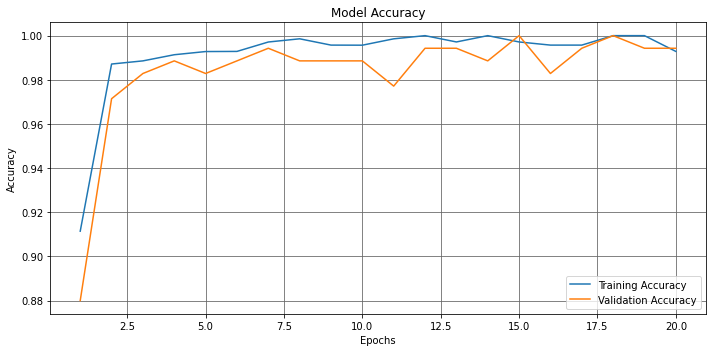

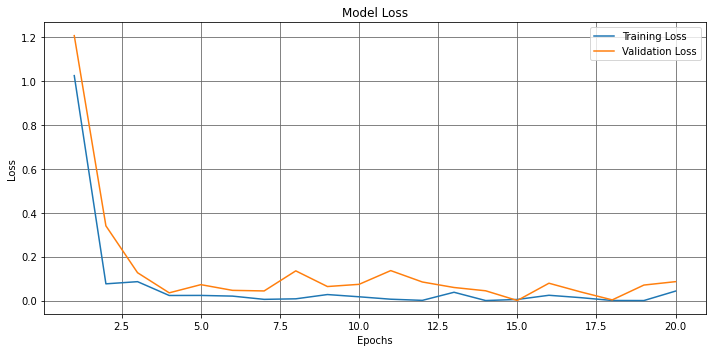

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 3, 2048)        8192      
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 33,034,113
Trainable params: 9,442,305
Non-trainable params: 23,591,808
__________________________________

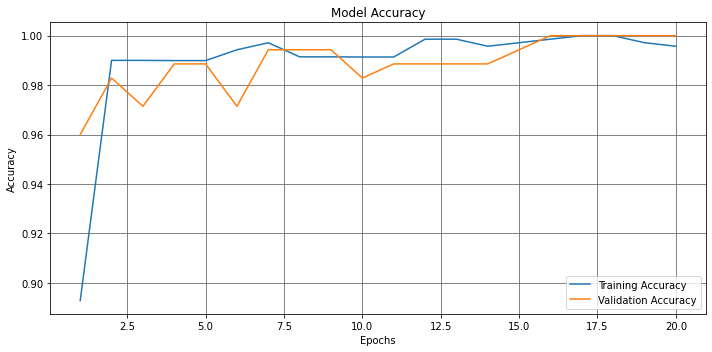

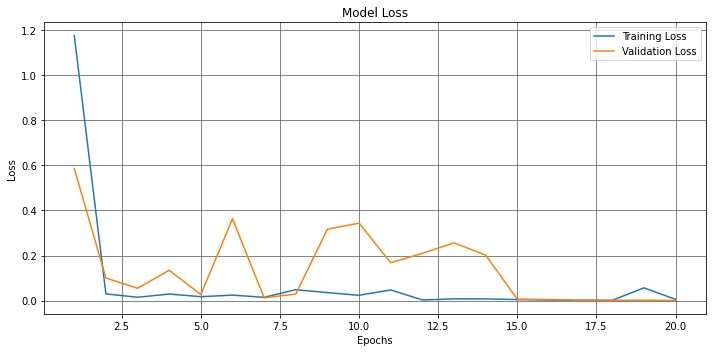

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 3, 3, 2048)        8192      
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 33,034,113
Trainable params: 9,442,305
Non-trainable params: 23,591,808
__________________________________

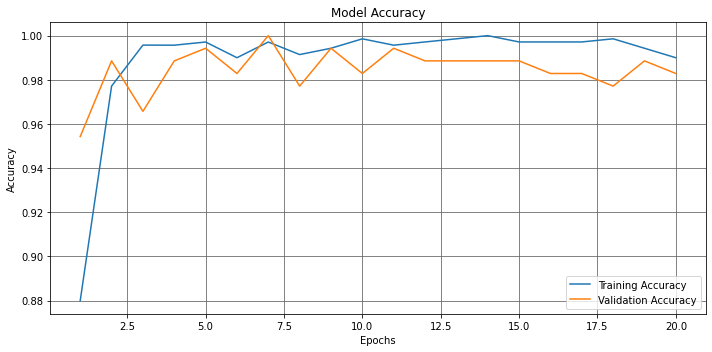

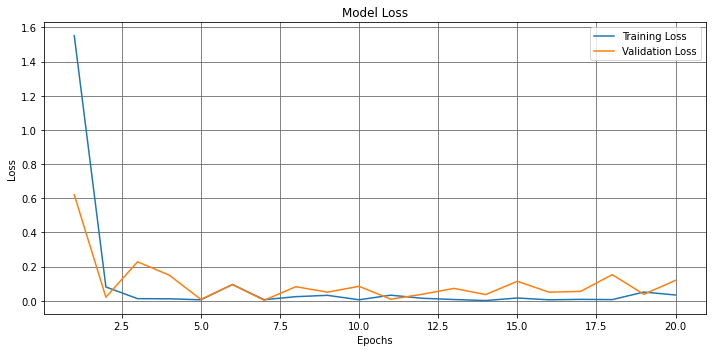

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 3, 3, 2048)        8192      
_________________________________________________________________
flatten_4 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 33,034,113
Trainable params: 9,442,305
Non-trainable params: 23,591,808
__________________________________

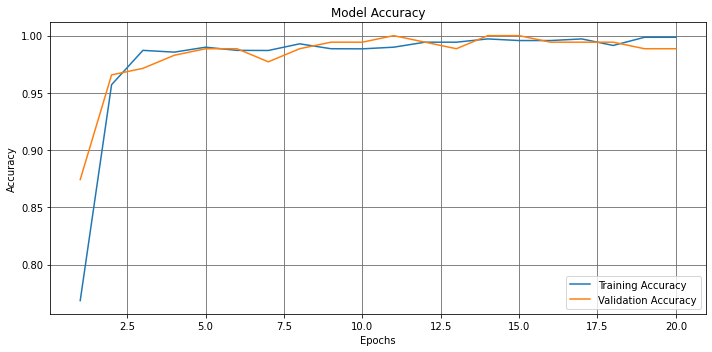

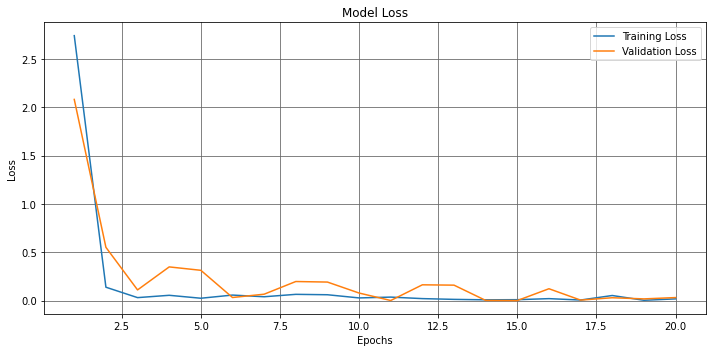

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 3, 3, 2048)        8192      
_________________________________________________________________
flatten_5 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               9437696   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 33,034,113
Trainable params: 9,442,305
Non-trainable params: 23,591,808
__________________________________

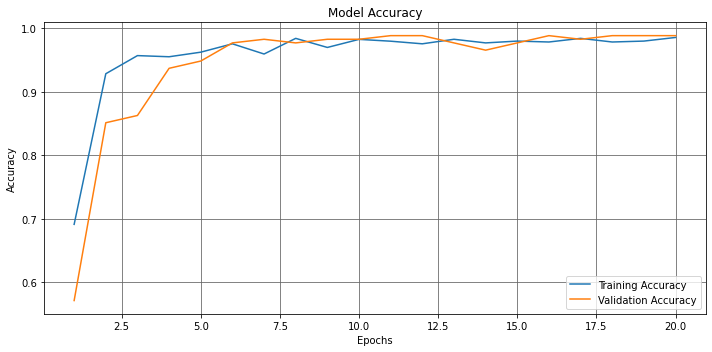

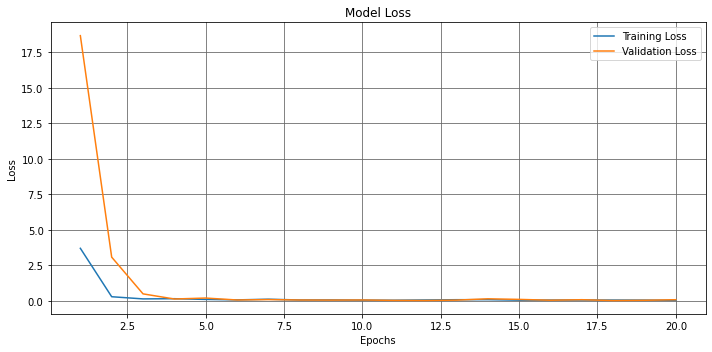

This is the plot of the recorded Accuracy per Droupout Rate
[0.9675, 0.9725, 0.9525, 0.9825, 0.98]


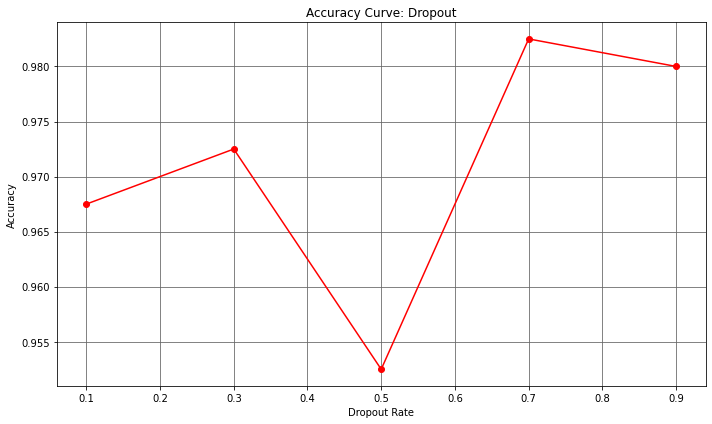

CPU times: user 59min 25s, sys: 1min 58s, total: 1h 1min 23s
Wall time: 34min 39s


In [ ]:
%%time
param_tuning_with_dropout( ResNet50, dropout_rates=[0.1, 0.3, 0.5, 0.7, 0.9])

###<h3><strong>Changing Activation Type</strong></h3>

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 3, 3, 2048)        8192      
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               9437696   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 33,034,113
Trainable params: 9,442,305
Non-trainable params: 23,591,808
__________________________________

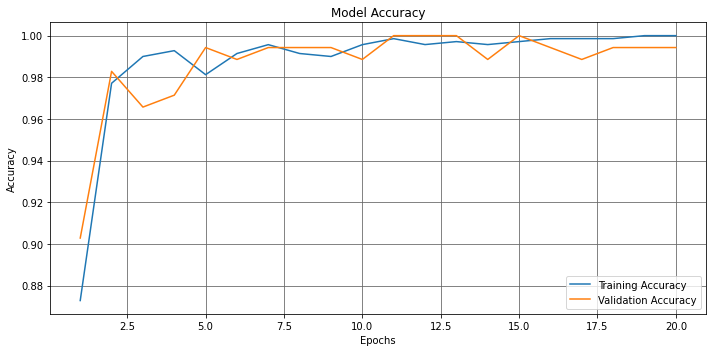

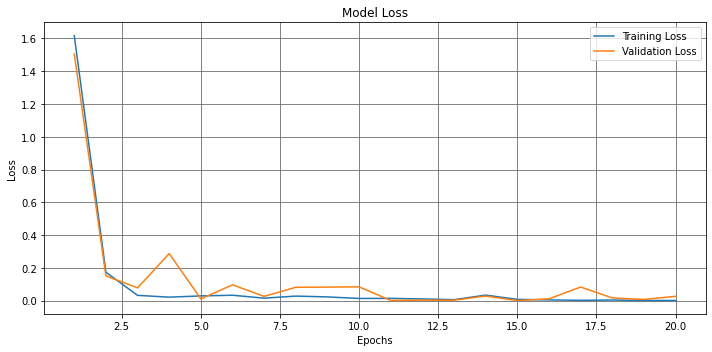

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
dropout_7 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 3, 3, 2048)        8192      
_________________________________________________________________
flatten_7 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               9437696   
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 513       
Total params: 33,034,113
Trainable params: 9,442,305
Non-trainable params: 23,591,808
__________________________________

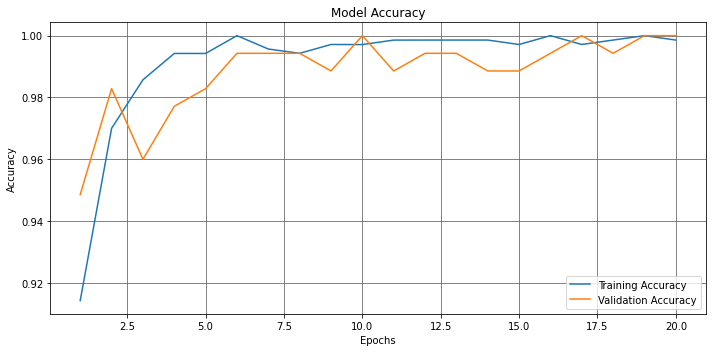

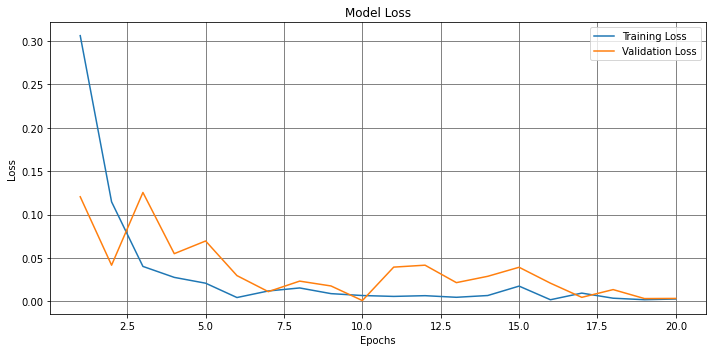

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
dropout_8 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 3, 3, 2048)        8192      
_________________________________________________________________
flatten_8 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               9437696   
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 513       
Total params: 33,034,113
Trainable params: 9,442,305
Non-trainable params: 23,591,808
__________________________________

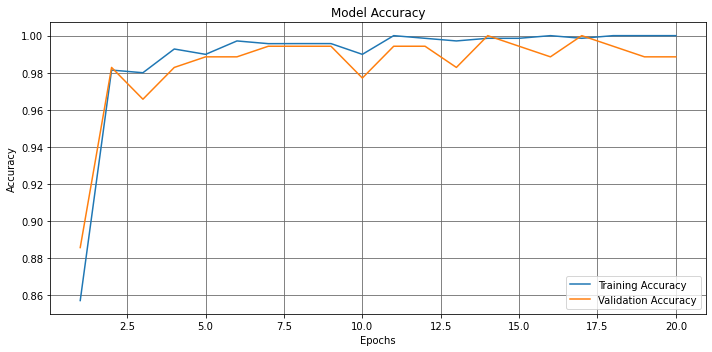

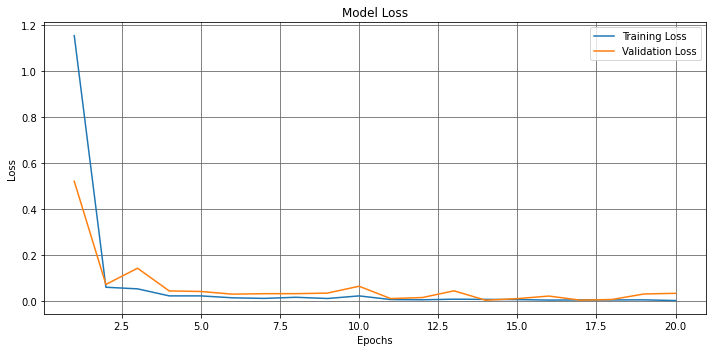

This is the plot of the recorded Accuracy per Activation Type
[0.98, 0.98, 0.985]


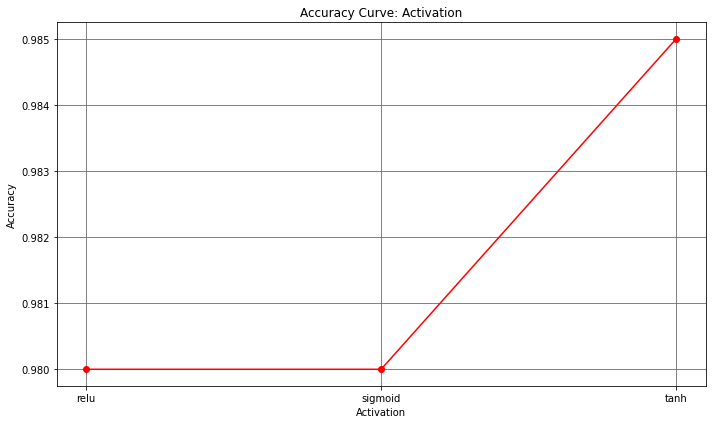

CPU times: user 35min 52s, sys: 1min 5s, total: 36min 58s
Wall time: 20min 43s


In [ ]:
%%time
param_tuning_with_activation( ResNet50, activation_types=["relu","sigmoid","tanh"] )

###<h3><strong>Changing the No. of Nodes</strong></h3>

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
dropout_9 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 3, 3, 2048)        8192      
_________________________________________________________________
flatten_9 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               9437696   
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 513       
Total params: 33,034,113
Trainable params: 9,442,305
Non-trainable params: 23,591,808
__________________________________

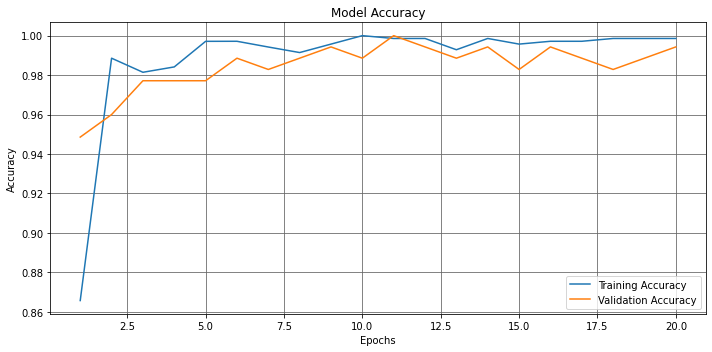

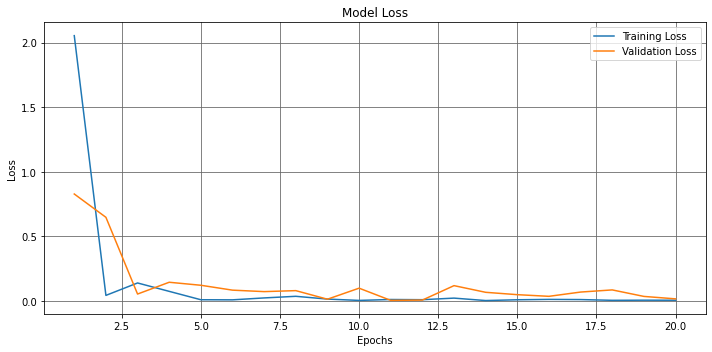

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
dropout_10 (Dropout)         (None, 3, 3, 2048)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 3, 3, 2048)        8192      
_________________________________________________________________
flatten_10 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              18875392  
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 1025      
Total params: 42,472,321
Trainable params: 18,880,513
Non-trainable params: 23,591,808
________________________________

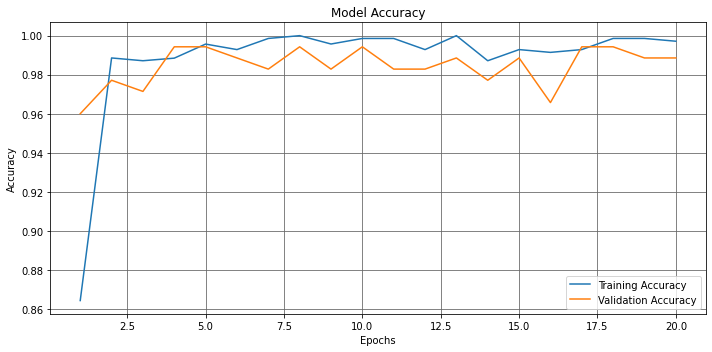

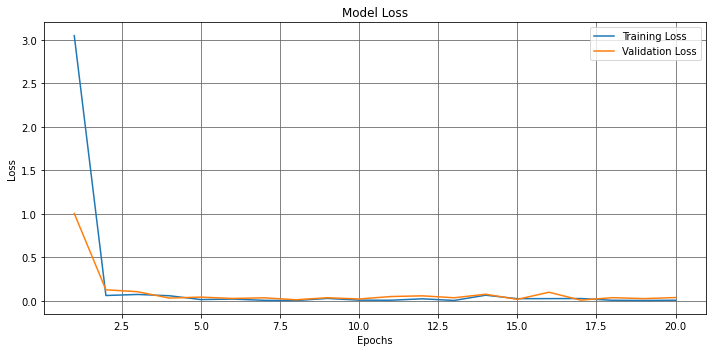

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
dropout_11 (Dropout)         (None, 3, 3, 2048)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 3, 3, 2048)        8192      
_________________________________________________________________
flatten_11 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 2048)              37750784  
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 2049      
Total params: 61,348,737
Trainable params: 37,756,929
Non-trainable params: 23,591,808
________________________________

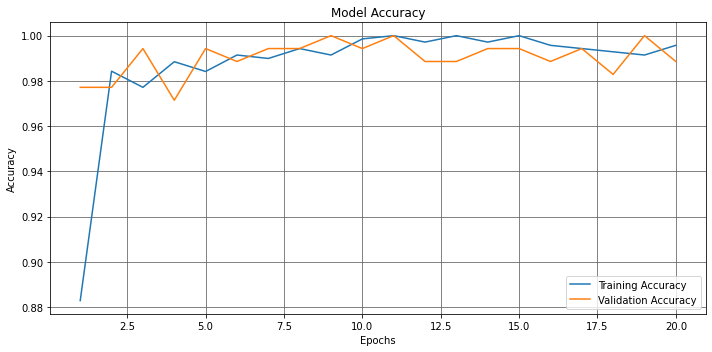

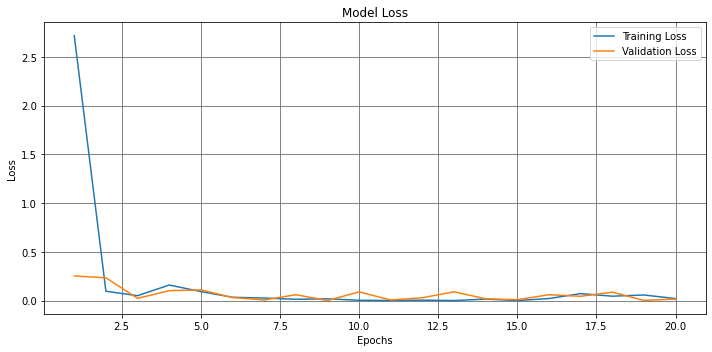

This is the plot of the recorded Accuracy per Number of Nodes in the head of a Transfer Learning model
[0.9875, 0.975, 0.99]


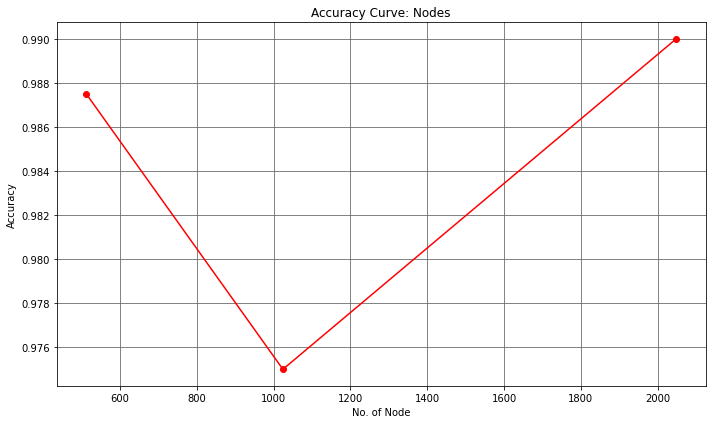

CPU times: user 53min 10s, sys: 1min 14s, total: 54min 25s
Wall time: 32min 29s


In [ ]:
%%time
param_tuning_with_Nodes( ResNet50, set_of_nodes = [512,1024,2048] )

###<h3><strong>Building the Best Model with Optimum Values of Hyperparameter</strong></h3><br>

The hyperparameters that have been tested for tuning are as follows: <strong>Dropout Rate</strong>, <strong>Activation</strong> in the hidden layers, and the No. of <strong>Nodes</strong> in the head of the model.

The default values of hyperparameters of the baseline model are as follows:
<ul>
<li>dropout_rate = 0.5</li>
<li>dense_node = 512</li>
<li>activation = "relu"</li>
</ul>

which gives an <strong>accuracy = 0.9775</strong> in the validation set.

On the other hand, during the hyperparameter tuning, it is observed that the optimum values for the said hyperparameters are as follows.

<ul>
<li>dropout_rate = 0.7</li>
<li>dense_node = 2048</li>
<li>activation = "tanh"</li>
</ul>

which gives the accuracy of <strong>0.9825</strong>, <strong>0.99</strong>, and <strong>0.985</strong> respectively. So these are the values that we will be using to improve the performance of the model. 



In [ ]:
%%time
Tuned_Model_ResNet50 = model_builder(ResNet50, droupout_rate=0.5, dense_node=512, activation_type="tanh", learning_rate=0.001)
Tuned_Model_ResNet50

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
dropout_14 (Dropout)         (None, 3, 3, 2048)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 3, 3, 2048)        8192      
_________________________________________________________________
flatten_14 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               9437696   
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 513       
Total params: 33,034,113
Trainable params: 9,442,305
Non-trainable params: 23,591,808
_________________________________

In [ ]:
%%time
Training_History_TunedResNet50 = model_trainer(Tuned_Model_ResNet50, epochs=20)
Training_History_TunedResNet50

Epoch 1/20
50/50 [==============================] - 24s 418ms/step - loss: 1.3697 - accuracy: 0.8414 - val_loss: 1.2999 - val_accuracy: 0.7829
Epoch 2/20
50/50 [==============================] - 20s 395ms/step - loss: 0.1283 - accuracy: 0.9671 - val_loss: 0.1470 - val_accuracy: 0.9543
Epoch 3/20
50/50 [==============================] - 20s 395ms/step - loss: 0.0406 - accuracy: 0.9900 - val_loss: 0.0716 - val_accuracy: 0.9829
Epoch 4/20
50/50 [==============================] - 20s 406ms/step - loss: 0.0409 - accuracy: 0.9841 - val_loss: 0.0362 - val_accuracy: 0.9886
Epoch 5/20
50/50 [==============================] - 20s 393ms/step - loss: 0.0204 - accuracy: 0.9914 - val_loss: 0.0719 - val_accuracy: 0.9829
Epoch 6/20
50/50 [==============================] - 20s 394ms/step - loss: 0.0210 - accuracy: 0.9914 - val_loss: 0.0251 - val_accuracy: 0.9886
Epoch 7/20
50/50 [==============================] - 20s 396ms/step - loss: 0.0151 - accuracy: 0.9942 - val_loss: 0.0444 - val_accuracy: 0.9886

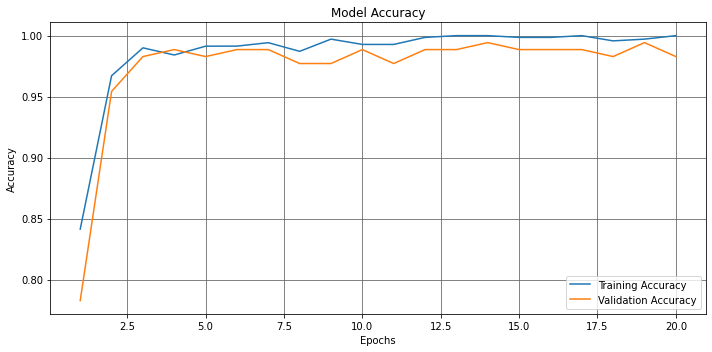

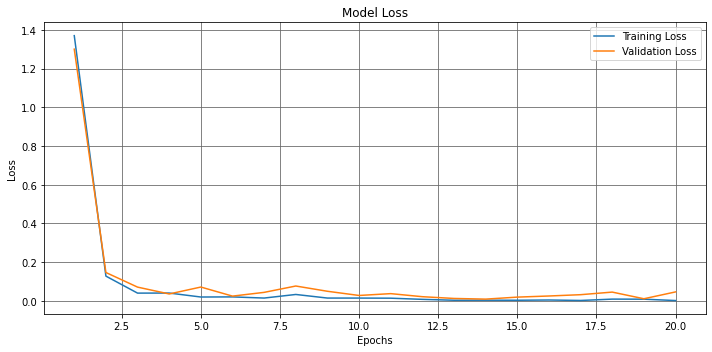

In [ ]:
TunedResNet50_Training_Results = training_result_visualizer(Training_History_TunedResNet50["history"])
TunedResNet50_Training_Results

Accuracy: 0.9875


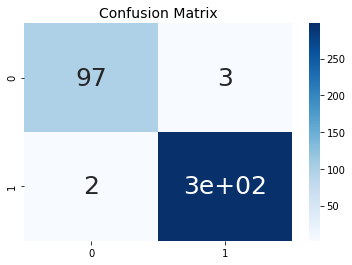

CPU times: user 12.5 s, sys: 414 ms, total: 12.9 s
Wall time: 7.36 s


In [ ]:
%%time
Accuracy_Score(Validation_Path, Training_History_TunedResNet50["model"])

After some trial and error, it turns out that changing the activation from "relu" to "tanh" will increase the accuracy of the model from 0.9775 to 0.9875 which is only one percent. 

##<h3><strong>Applying the Tuned Model on Test Set for Final Accuracy</strong></h3>

After choosing the best paramater value in hyperparameter tuning, we are now going to test the accuracy of the tuned model on the test set to report the final accuracy.

Accuracy: 0.985


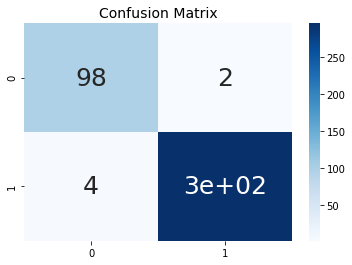

CPU times: user 12 s, sys: 403 ms, total: 12.4 s
Wall time: 6.85 s


In [ ]:
%%time
Accuracy_Score(Test_Path, Training_History_TunedResNet50["model"])

##<h3><strong>Summary and Conclusion</strong></h3>

The following practices have been performed in this exercise:
<ul>
<li>Splitting the Dataset</li>
<li>Data Visualization</li>
<li>Creating Helper Functions</li>
<li>Building the Model</li>
<li>Training the Model</li>
<li>Evaluating the Model</li>
<li>Hyperparameter Tuning</li>
<li>Testing the Accuracy of the Model on the Test Set</li>
</ul>

<strong>Before Hyperparameter Tuning</strong><br>
Validation Accuracy: 0.9775

<strong>After Hyperparameter Tuning</strong><br>
Validation Accuracy: 0.9875

<strong>Final Accuracy</strong><br>
Test Accuracy: 0.985

It is observed that the model achieved a fairly high accuracy of 0.9775 on the Validation Set even without highperparameter Tuning. One of the reason for achieving this kind of accuracy is because of the nature of the images. The difference between the images of the two class are very noticeable (see the images below). Even though the model achieved a significanlty high accuracy, it is also a good practice to apply hyperparameter tuning to really reach the maximum potential accuracy of the model where it achived 0.985 accuracy on the Validation Set. Finally, the accuracy of the model on Test Set is 0.985 which indicates that the model really did a good job classifying ship and no-ship.


<strong>Class: ship</strong>
![](https://i.imgur.com/tLsSoTz.png)
<strong>Class: no-ship</strong>
![](https://i.imgur.com/Q3daQMC.png)